<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

В качестве временного ряда используем стоимость акций Банка Америки за период 12.2016-11.2017.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

# Входные данные
df = yf.Ticker("BAC").history(start='2016-12-01', end='2017-12-01')
df = df.reset_index()
df['Date'] = df['Date'].dt.strftime('%Y-%m')
df = df.groupby('Date')['Close'].agg('mean').reset_index()
periods = [i for i in range(1, df.shape[0]+1)]
fact = df.Close.values

In [2]:
def holt_winters(df, al1, al2, al3):
    # Инициализация гиперпараметров
    a = []
    b = []
    f = []
    x = []

    t = df.shape[0]
    tau = 1
    L = 4
    k = int(len(periods) / L)
    
    # Вычисление начальных значений коэффициентов b, a, F
    n = len(periods)
    sum_x = sum(periods)
    sum_y = sum(fact)
    sum_x_squared = sum([i**2 for i in periods])
    sum_xy = sum([periods[i]*fact[i] for i in range(n)])
    
    a0 = (n*sum_xy - sum_x*sum_y) / (n*sum_x_squared - sum_x**2)  # Коэффициент наклона
    b0 = (sum_y - a0*sum_x) / n  # Свободный член
    a.append(a0)
    b.append(b0)
    
    estimations = [a0*x+b0 for x in periods]
    ratios = [fact[i] / estimations[i] for i in range(n)]
    
    for i in range(L):
        new_f = []
        for j in [x*4+i for x in range(0,k)]:
            new_f.append(ratios[j])
        f.append(sum(new_f) / k)
        
    for i in range(1, t+1):
        new_b = al1 * fact[i-1] / f[i-1] + (1-al1) * (b[i-1] + a[i-1])
        b.append(new_b)
        new_a = al2 * (b[i] - b[i-1]) + (1-al2) * a[i-1]
        a.append(new_a)
        new_f = al3 * fact[i-1] / b[i] + (1-al3) * f[i-1]
        f.append(new_f)
        ax = a[(i-1)//4*4]
        bx = b[(i-1)//4*4]
        
        tau = i%4
        if tau == 0:
            tau = 4
        
        new_x = (tau*ax + bx) * f[i-1]
        x.append(new_x)
        
    # Получим предсказания
    preds = []
    for i in range(1, 5):
        tau = i%4
        if tau == 0:
            tau = 4
        new_x = (i*a[-1] + b[-1]) * f[i-5]
        preds.append(new_x)
        
    return a, b, f, x, preds

In [3]:
a, b, f, x, preds = holt_winters(df, 0.4, 0.3, 0.6)

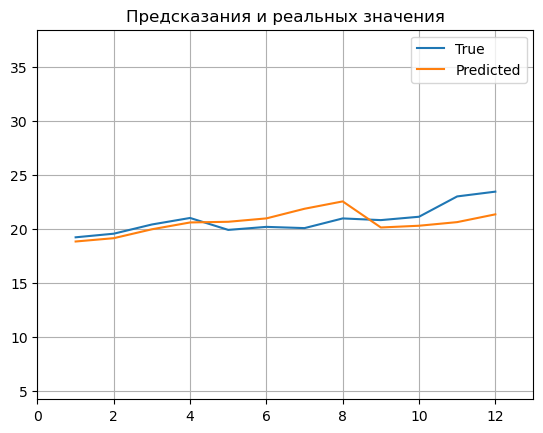

In [4]:
plt.plot(periods, fact, label='True')
plt.plot(periods, x, label='Predicted')
plt.legend()
plt.title('Предсказания и реальных значения')
plt.axis([0, df.shape[0]+1, min(fact)-15, max(fact)+15])
plt.grid()

In [5]:
test_df = yf.Ticker("BAC").history(start='2017-12-01', end='2018-04-01')
test_df = test_df.reset_index()
test_df['Date'] = test_df['Date'].dt.strftime('%Y-%m')
test_df = test_df.groupby('Date')['Close'].agg('mean').reset_index()

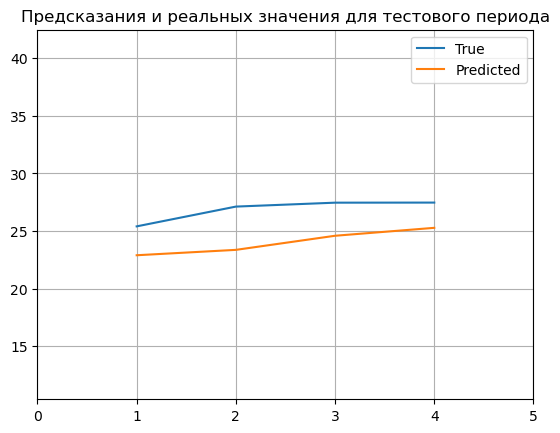

In [8]:
plt.plot([i for i in range(1, test_df.shape[0]+1)], test_df.Close.values, label='True')
plt.plot([i for i in range(1, test_df.shape[0]+1)], preds, label='Predicted')
plt.legend()
plt.title('Предсказания и реальных значения для тестового периода')
plt.axis([0, test_df.shape[0]+1, min(test_df.Close)-15, max(test_df.Close)+15])
plt.grid()